--- [Step 0: Installing and Importing Libraries] ---
Cloning into 'Amthal'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 76 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 1.47 MiB | 3.56 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Amthal
--- [Step 1: Loading Data] ---
Data loaded successfully. Found 4078 instances.

Calculating standardized residuals for the heatmap...
Generating the heatmap...


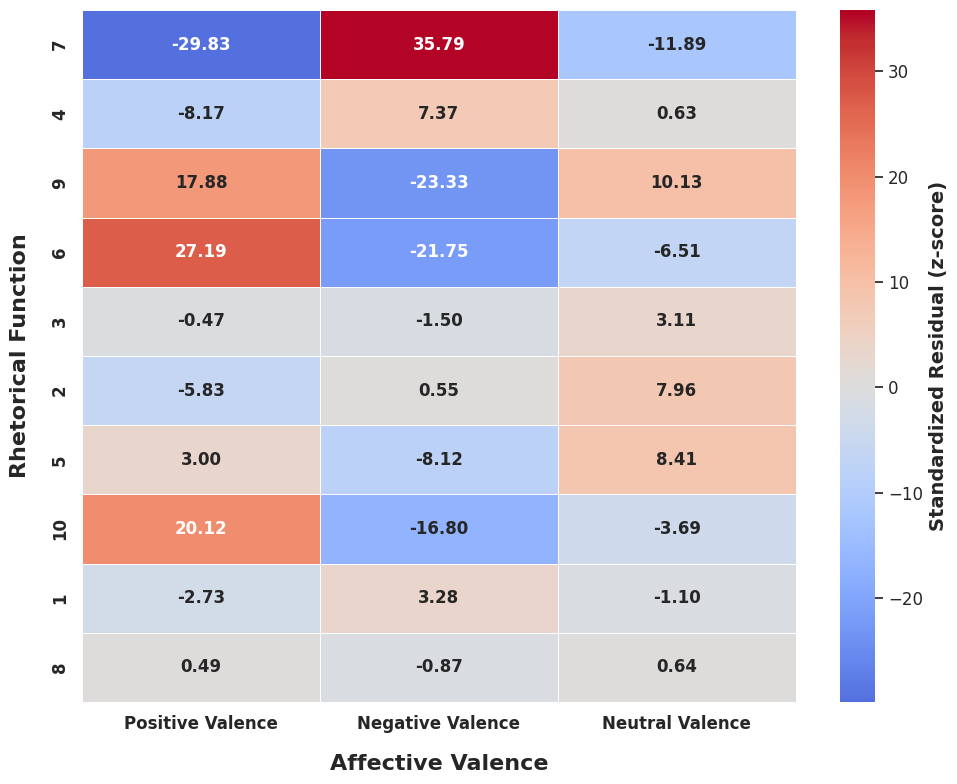

In [1]:

#@title  **Association between Valence and Rhetorical Function.**


# --- [الخطوة 0: التثبيت والاستيراد] ---
print("--- [Step 0: Installing and Importing Libraries] ---")
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
print("--- [Step 1: Loading Data] ---")
# ⚠️⚠️⚠️  الرجاء التأكد من أن هذا المسار صحيح في بيئتك
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()



# --- 2. حساب جدول البقايا المعيارية (نفس الكود من الجدول 3) ---
print("Calculating standardized residuals for the heatmap...")

# إنشاء جدول العد الخام
contingency_table = pd.crosstab(df['Rhetorical_Function'], df['Valence'])
# استخدام statsmodels للحصول على البقايا المعيارية الدقيقة
table = sm.stats.Table(contingency_table)
std_residuals_df = table.standardized_resids

# --- 3. تنسيق الجدول للرسم ---
# الخطوة أ: إعادة ترتيب الأعمدة لترتيب منطقي
cols_to_display = []
for col in ['إيجابي', 'سلبي', 'محايد']:
    if col in std_residuals_df.columns:
        cols_to_display.append(col)
final_table = std_residuals_df[cols_to_display]

# الخطوة ب: ترجمة أسماء الأعمدة والفهرس إلى الإنجليزية
valence_cols_map = {'إيجابي': 'Positive Valence', 'سلبي': 'Negative Valence', 'محايد': 'Neutral Valence'}
final_table.rename(columns=valence_cols_map, inplace=True)

function_index_map = {
    'امتنان': 'Gratitude', 'تشريع': 'Legislation', 'تعظيم': 'Glorification',
    'تقريب': 'Approximation', 'تمجيد': 'Exaltation', 'حجاج': 'Argumentation',
    'سرد': 'Narration', 'وصف': 'Description', 'وعد': 'Promise', 'وعيد': 'Warning'
}
final_table.rename(index=function_index_map, inplace=True)

# الخطوة ج: فرز الصفوف بناءً على إجمالي تكرار كل وظيفة
total_counts = df['Rhetorical_Function'].value_counts()
sorted_index = total_counts.index.map(lambda x: function_index_map.get(x, x))
final_table = final_table.reindex(sorted_index)


# --- 4. إعداد الرسم البياني الاحترافي (Heatmap) ---
print("Generating the heatmap...")
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(10, 8))

# إنشاء الخريطة الحرارية
# cmap='coolwarm' هو الخيار المثالي لأنه ثنائي القطب (أزرق للسلبي، أحمر للإيجابي)
# center=0 يضمن أن اللون الأبيض (المحايد) يقع عند الصفر تمامًا
heatmap = sns.heatmap(
    final_table,
    annot=True,            # عرض الأرقام على الخلايا
    fmt=".2f",             # تنسيق الأرقام بمنزلتين عشريتين
    linewidths=.5,
    cmap='coolwarm',       # لوحة ألوان ممتازة للبيانات الموجبة/السالبة
    center=0,              # جعل الصفر هو مركز لوحة الألوان
    cbar_kws={'label': 'Standardized Residual (z-score)'},
    ax=ax
)

# --- 5. إضافة التحسينات البصرية ---
ax.set_xlabel(
    'Affective Valence',
    fontsize=16,           # حجم أكبر قليلًا
    fontweight='bold',
    labelpad=15
)
ax.set_ylabel(
    'Rhetorical Function',
    fontsize=16,
    fontweight='bold',
    labelpad=15
)

# تنسيق قيم المحاور
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# تكبير النصوص داخل الخلايا وجعلها عريضة
for t in heatmap.texts:
    t.set_fontsize(12)
    t.set_fontweight('bold')

# تكبير وسهولة قراءة مقياس الألوان (Colorbar)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(14)
cbar.ax.yaxis.label.set_fontweight('bold')

# إزالة الإطار الجانبي
sns.despine(left=True, bottom=True)

# ضبط المسافات النهائية
plt.tight_layout()
plt.savefig('Valence_Function_Heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


--- [Step 0: Installing and Importing Libraries] ---
Cloning into 'Amthal'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 76 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 1.47 MiB | 3.51 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Amthal/Amthal
--- [Step 1: Loading Data] ---
Data loaded successfully. Found 4078 instances.

Calculating relative distribution of Valence for each Rhetorical Function...
Generating the 100% stacked bar chart...


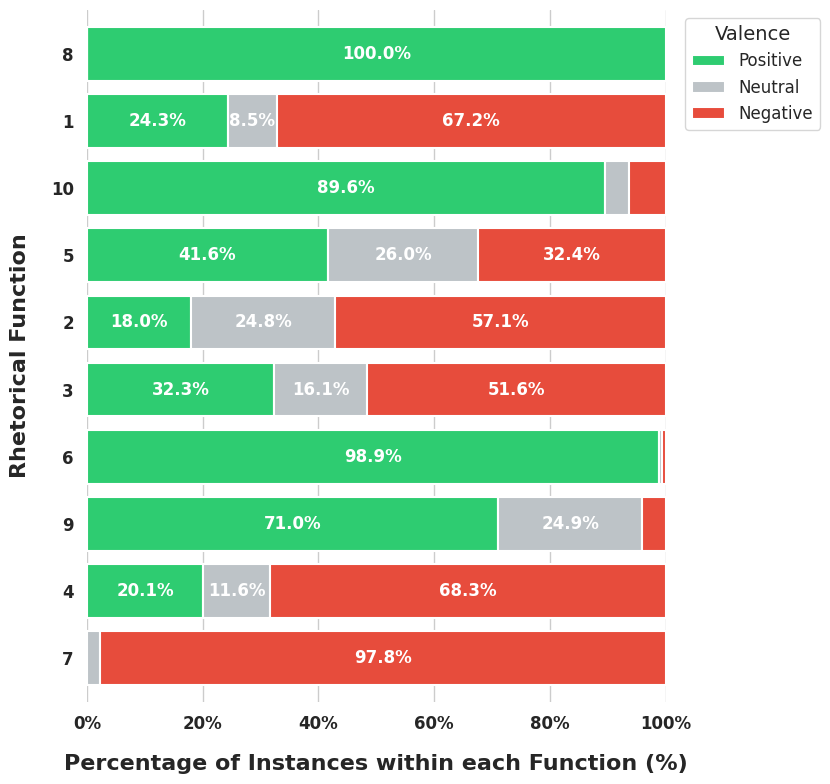

In [2]:
#@title  **# Figure 9b — Stacked bar chart showing valence distribution by rhetorical function.**


# --- [الخطوة 0: التثبيت والاستيراد] ---
print("--- [Step 0: Installing and Importing Libraries] ---")
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
print("--- [Step 1: Loading Data] ---")
# ⚠️⚠️⚠️  الرجاء التأكد من أن هذا المسار صحيح في بيئتك
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]
    df['Valence']=[Valence_dic[i]['ar'] for i in df.Valence]
    df['Revelation_Phase']=[Revelation_Phase_dic[i]['ar'] for i in df.Revelation_Phase]
    df['Abstraction_Level']=[Abstraction_Level_dic[i]['ar'] for i in df.Abstraction_Level]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()



# ترجمة عمود Valence إلى الإنجليزية
valence_map = {'إيجابي': 'Positive', 'سلبي': 'Negative', 'محايد': 'Neutral'}
df['Valence_En'] = df['Valence'].map(valence_map)


# --- 2. حساب التوزيع النسبي للشحنات لكل وظيفة بلاغية ---
print("Calculating relative distribution of Valence for each Rhetorical Function...")

# الخطوة أ: إنشاء جدول طوارئ (العد الخام)
func_valence_counts = pd.crosstab(df['Rhetorical_Function'], df['Valence_En'])

# الخطوة ب: التطبيع (Normalization) للحصول على نسب مئوية لكل صف (وظيفة)
func_valence_props = func_valence_counts.div(func_valence_counts.sum(axis=1), axis=0) * 100

# فرز الصفوف بناءً على إجمالي تكرار كل وظيفة لجعل الرسم منظمًا
total_counts = df['Rhetorical_Function'].value_counts()
func_valence_props = func_valence_props.reindex(total_counts.index)
# إعادة ترتيب الأعمدة لترتيب منطقي
func_valence_props = func_valence_props[['Positive', 'Neutral', 'Negative']]


# --- 3. إعداد الرسم البياني الاحترافي (100% Stacked Bar Chart) ---
print("Generating the 100% stacked bar chart...")
sns.set_theme(style="whitegrid")

# إنشاء لوحة الرسم
fig, ax = plt.subplots(figsize=(10, 8))

# استخدام لوحة ألوان دلالية
colors = {'Positive': '#2ecc71', 'Neutral': '#bdc3c7', 'Negative': '#e74c3c'}

# رسم الأعمدة المكدسة
func_valence_props.plot(
    kind='barh',      # 'barh' لإنشاء أعمدة أفقية
    stacked=True,
    color=[colors[col] for col in func_valence_props.columns],
    ax=ax,
    width=0.8,
    edgecolor='white',
    linewidth=1.5
)

# --- 4. إضافة التحسينات البصرية والتعليقات ---

ax.set_xlabel(
    'Percentage of Instances within each Function (%)',
    fontsize=16,
    fontweight='bold',
    labelpad=15
)
ax.set_ylabel(
    'Rhetorical Function',
    fontsize=16,
    fontweight='bold',
    labelpad=15
)

# تنسيق قيم المحاور
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# تنسيق قيم المحور السيني كنسبة مئوية
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.set_xlim(0, 100)

# إضافة التسميات (النسب المئوية) داخل كل جزء من العمود بخط أكبر وواضح
for c in ax.containers:
    labels = [f'{w:.1f}%' if w > 8 else '' for w in c.datavalues]
    ax.bar_label(
        c,
        labels=labels,
        label_type='center',
        color='white',
        fontsize=12,
        fontweight='bold'
    )

# تحسين الأسطورة
ax.legend(
    title='Valence',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=12,
    title_fontsize=14
)

# إزالة الإطار الزائد
sns.despine(left=True, bottom=True)

# ترجمة تسميات المحور الصادي
function_index_map = {
    'امتنان': 'Gratitude', 'تشريع': 'Legislation', 'تعظيم': 'Glorification',
    'تقريب': 'Approximation', 'تمجيد': 'Exaltation', 'حجاج': 'Argumentation',
    'سرد': 'Narration', 'وصف': 'Description', 'وعد': 'Promise', 'وعيد': 'Warning'
}
ax.set_yticklabels([function_index_map.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()])

# --- 5. الحفظ والعرض ---
plt.tight_layout(rect=[0, 0, 0.85, 1])  # ترك مساحة للأسطورة
plt.savefig('Figure_7b_Valence_by_Function.png', dpi=300, bbox_inches='tight')
plt.show()
